# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
#from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy

from helpers.normalization import normalize, denormalize, renormalize
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.


In [2]:
#import importlib
#importlib.reload(helpers.normalization)

<module 'helpers.normalization' from '/home/jabbate/plasma-profile-predictor/helpers/normalization.py'>

In [2]:
%matplotlib inline
font={'family': 'Times New Roman',
      'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

# Analysis

In [64]:
#file_path='/home/wconlin/run_results_9_26/model-conv1d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_01Oct19-08-59_Scenario-480.h5'
file_path='/home/wconlin/run_results_11_2/model-conv1d_profiles-thomson_temp_EFITRT1-thomson_dens_EFITRT1-press_EFITRT1-ffprime_EFITRT1-q_EFIT01_act-pinj-curr-tinj_targ-thomson_temp_EFITRT1-thomson_dens_EFITRT1_profLB-1_actLB-6_ftop-True_03Nov19-22-24.h5'
#file_path='/home/wconlin/run_results_10_4/model-conv1d_profiles-temp-dens-q_EFIT01_act-pinj-curr-tinj-gasA_targ-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_06Oct19-10-12_Scenario-164.h5'
#file_path='/home/wconlin/run_results_10_4/model-conv1d_profiles-temp-dens-q_EFIT01_act-pinj-curr-tinj-gasA_targ-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_06Oct19-22-29_Scenario-244.h5'
#file_path='/home/wconlin/run_results_9_26/model-conv2d_profiles-temp-dens-press_EFIT01-ffprime_EFIT01-q_EFIT01-itemp-rotation_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_28Sep19-03-42_Scenario-138.h5'
#file_path='/home/wconlin/run_results_10_4/model-conv2d_profiles-temp-dens-press_EFIT01-ffprime_EFIT01-q_EFIT01_act-pinj-curr-tinj-gasA_targ-temp_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_05Oct19-03-47_Scenario-20.h5'
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv1d_profiles-thomson_temp_EFITRT1-thomson_dens_EFITRT1-press_EFITRT1-ffprime_EFITRT1-q_EFIT01_act-pinj-curr-tinj_targ-thomson_temp_EFITRT1-thomson_dens_EFITRT1_profLB-1_actLB-6_ftop-True_03Nov19-22-24.h5
loaded dict: model-conv1d_profiles-thomson_temp_EFITRT1-thomson_dens_EFITRT1-press_EFITRT1-ffprime_EFITRT1-q_EFIT01_act-pinj-curr-tinj_targ-thomson_temp_EFITRT1-thomson_dens_EFITRT1_profLB-1_actLB-6_ftop-True_03Nov19-22-24_params.pkl
with parameters: dict_keys(['actuator_names', 'input_profile_names', 'target_profile_names', 'scalar_input_names', 'profile_downsample', 'model_type', 'model_kwargs', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'batch_size', 'epochs', 'flattop_only', 'predict_deltas', 'raw_data_path', 'process_data', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_loo

In [65]:
scenario['sig_names']

['thomson_temp_EFITRT1',
 'thomson_dens_EFITRT1',
 'press_EFITRT1',
 'ffprime_EFITRT1',
 'q_EFIT01',
 'thomson_temp_EFITRT1',
 'thomson_dens_EFITRT1',
 'pinj',
 'curr',
 'tinj']

In [66]:
#import importlib
#importlib.reload(helpers.data_generator)
traindata, valdata, normalization_dict = helpers.data_generator.process_data('/scratch/gpfs/jabbate/mixed_data/final_data_batch_204.pkl', #scenario['raw_data_path'],
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2,
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'], #pruning_functions, 
                                                      #excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False) #scenario['shuffle_generators'])

Loading
Signals: curr, ffprime_EFITRT1, pinj, press_EFITRT1, q_EFIT01, thomson_dens_EFITRT1, thomson_temp_EFITRT1, tinj
Number of useable shots:  48
Number of shots used:  48
Total number of timesteps:  12862
Shots with Complete NaN: 
3159 samples total
Removing NaN
Removed 0 samples
3159 samples remaining
Removing dudtrip
Removed 65 samples
3094 samples remaining
Removing weird I-coils
Removed 445 samples
2649 samples remaining
Removing ECH
Removed 158 samples
2491 samples remaining
Removing weird gas
Removed 1156 samples
1335 samples remaining
Removing ECH
Removed 0 samples
1335 samples remaining
Removing weird gas
Removed 0 samples
1335 samples remaining
1335 samples remaining after pruning
nonrandomized
Total number of samples:  1335
Number of training samples:  1335
Number of validation samples:  0


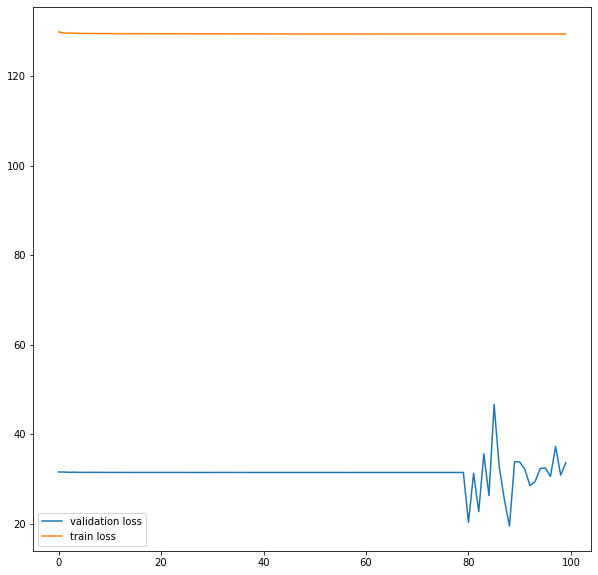

In [67]:
plt.plot(scenario['history']['val_loss'],label='validation loss')
plt.plot(scenario['history']['loss'],label='train loss')
plt.legend()
#plt.ylim(0,.1)
plt.show()

In [68]:
denormed_traindata=helpers.normalization.denormalize(traindata,normalization_dict)

Denormalizing: 100%|##########| 21/21 [00:00<00:00, 3595.85it/s]


# Design your own shot

In [72]:
def plot_prediction_for_shot_at_time(shotnum,t,filename=None,denormalized=False):

    if denormalized:
        proper_traindata=denormed_traindata
    else:
        proper_traindata=traindata
    
    psi = np.linspace(0,1,scenario['profile_length'])
    sigs=scenario['actuator_names']
    profiles=scenario['target_profile_names']
    input_profiles=scenario['input_profile_names']
    changed_input_keys=[]
    changed_profile_keys=[] #'thomson_dens_EFITRT1']

    sig_names={'curr': 'ip (A)',
           'temp':'Te (keV)', 
           'dens': 'ne (10^19 m^-3)',
           'q_EFIT01':'q',
           'pinj': 'pinj (kW)', 
           'gasA': 'gasA (V)',
           'tinj':'tinj (Nm)'}
    sig_lims={
              'thomson_temp_EFITRT1': [0,2e3],             
              'curr': [0,2e6],
              'temp':[0,10], 
              'dens': [0,10],
              'pinj': [0,1.5e4], 
              'gasA': [0,8]}
    
    shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]

    time_offset=np.argmin(abs(traindata['time'][shot_indices,-scenario['lookahead']-1]-t))

    #prev_targets=train_generator[shot_indices[0]+time_offset-1][1]

    inputs=train_generator[shot_indices[0]+time_offset][0]
    targets=train_generator[shot_indices[0]+time_offset][1]
    
    changed_input=copy.deepcopy(inputs)
    for key in changed_input_keys:
        #changed_input['input_past_{}'.format(key)]=np.array([np.linspace(-2,0,actuator_lookback)])
        #changed_input['input_past_{}'.format(key)]=np.zeros(changed_input['input_past_{}'.format(key)].shape)

        prev=traindata[key][shot_indices[0]+time_offset][-scenario['lookahead']-1]
        #changed_input['input_future_{}'.format(key)]=np.array([[prev]*scenario['lookahead']])
        #changed_input['input_future_{}'.format(key)]=np.zeros(changed_input['input_future_{}'.format(key)].shape)
        changed_input['input_future_{}'.format(key)]=np.array([np.linspace(prev,prev+1,scenario['lookahead'])]) 
        #changed_input['input_future_{}'.format(key)]+=2
        #changed_input['input_past_{}'.format(key)]+=2
        #prev=traindata[key][shot_indices[0]+time_offset][-1]#0]
        #changed_input['input_past_{}'.format(key)]=np.array([[prev]*actuator_lookback])

    for key in changed_profile_keys:
        #changed_input['input_{}'.format(key)]=np.array([[[0]*scenario['profile_length']]])
        changed_input['input_{}'.format(key)]-=np.array([[.5*np.linspace(1,1,scenario['profile_length'])]])
        #changed_input['input_{}'.format(key)]+=np.array([targets['target_{}'.format(key)]])
    
    num_cols=2

    fig=plt.figure()
    for i,sig in enumerate(sigs):
        ax=fig.add_subplot(len(sigs),num_cols,i*num_cols+1)
        if len(traindata[sig][shot_indices].shape)>2:
            ax.plot(traindata['time'][shot_indices,-scenario['lookahead']-1],
                    np.mean(proper_traindata[sig][shot_indices,-scenario['lookahead']-1,:],axis=1),
                    c='b')
    #         ax.contourf(traindata['time'][shot_indices,-lookahead],
    #                 psi,
    #                 traindata[sig][shot_indices,-lookahead,::scenario['profile_downsample']].T)
            if denormalized:
                ax.set_ylim(sig_lims[sig])
            else:
                ax.set_ylim(-2,2)

        else:
#             ax.plot(traindata['time'][shot_indices[0],:-scenario['lookahead']-1],
#                             traindata[sig][shot_indices[0],:-scenario['lookahead']-1],
#                    c='b')
            #median=scenario['normalization_dict'][sig]['median']
            #iqr=scenario['normalization_dict'][sig]['iqr']
            ax.plot(traindata['time'][shot_indices,-scenario['lookahead']-1],
                    proper_traindata[sig][shot_indices,-scenario['lookahead']-1],
                    c='b',
                    label='True')
            if sig in changed_input_keys:
                changed_input_final=np.append(changed_input['input_past_{}'.format(sig)].squeeze(),changed_input['input_future_{}'.format(sig)].squeeze())
                if denormalized:
                    changed_input_final=helpers.normalization.denormalize_arr(changed_input_final,normalization_dict[sig])
                ax.plot(traindata['time'][shot_indices[0]+time_offset,:],
                        changed_input_final,
                        color='r',
                        label='Perturbation')
                ax.legend()
            if denormalized:
                ax.set_ylim(sig_lims[sig])
            else:
                if sig=='curr':
                    ax.set_ylim(-3,3)
                else:
                    ax.set_ylim(-3,3)


        ax.axvline(traindata['time'][shot_indices[0]+time_offset,-scenario['lookahead']-1],
                  color='r')
        ax.axvline(traindata['time'][shot_indices[0]+time_offset,-1],
                  color='g')
        ax.axvline(traindata['time'][shot_indices[0]+time_offset,0],
                  color='k')
        ax.set_xlim(0,np.amax(traindata['time'][shot_indices]))
        if sig in profiles:
            if sig in sig_names:
                ax.set_title('Average {}'.format(sig_names[sig]))
            else:
                ax.set_title('Average {}'.format(sig))
        else: 
            ax.set_title(sig_names[sig])

    # truths=train_generator[shot_indices[0]+time_offset][1]

#     for i,profile in enumerate(input_profiles):
#         ax=fig.add_subplot(len(input_profiles),num_cols,i*num_cols+1+1)

#         ax.plot(psi,inputs['input_{}'.format(profile)].squeeze(),c='g')
#         if profile in changed_profile_keys:
#             ax.plot(psi,changed_input['input_{}'.format(profile)].squeeze(),c='r')
#         ax.set_title('{}'.format(profile))
#         ax.axhline(0,color='k',alpha=.5)
#         ax.set_ylim(-2,2)

    predictions=model.predict_on_batch(inputs)
    changed_predictions=model.predict_on_batch(changed_input)
    for i,profile in enumerate(profiles):
        ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1)
        ax.plot(psi,
                proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
                label='Previous',
                c='k')
        ax.plot(psi,
                proper_traindata[profile][shot_indices[0]+time_offset][-1][::scenario['profile_downsample']],
                label='Next',
                c='g')
        if scenario['predict_deltas']:
            full_profile_prediction=traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+predictions[i].squeeze()
            if denormalized: 
                full_profile_prediction=helpers.normalization.denormalize_arr(full_profile_prediction,normalization_dict[profile])
            ax.plot(psi,
                    full_profile_prediction,
                    label='Prediction',
                    c='b')
            full_profile_prediction_perturbed=traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+changed_predictions[i].squeeze()
            if denormalized:
                full_profile_prediction_perturbed=helpers.normalization.denormalize_arr(full_profile_prediction_perturbed,normalization_dict[profile])
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        full_profile_prediction_perturbed,
                        label='Perturbed Prediction',
                        c='r')
        else:
            ax.plot(psi,
                    predictions[i].squeeze(),
                    label='Prediction',
                    c='b')
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        changed_predictions[i].squeeze(),
                        label='Perturbed Prediction',
                        c='r')
        ax.legend()
        if profile in sig_names:
            ax.set_title(sig_names[profile])
        else: 
            ax.set_title(profile)
        
        if denormalized:
            ax.set_ylim(sig_lims[profile])
        else:
            ax.set_ylim(-2,2)
        ax.axhline(0,color='k',alpha=.5)
        
#         ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1)

#         if scenario['predict_deltas']:
#             ax.plot(psi,targets['target_{}'.format(profile)].squeeze(),label='True',c='g')
#             ax.plot(psi,predictions[i].squeeze(),label='Prediction',
#                     c='b')
#             if len(changed_input_keys)+len(changed_profile_keys)>0:
#                 ax.plot(psi,changed_predictions[i].squeeze(),color='r',label='Perturbed Prediction')
#         else:
#             ax.plot(psi,
#                     targets['target_{}'.format(profile)].squeeze()-proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
#                     label='True',
#                     c='g')
#             ax.plot(psi,
#                     predictions[i].squeeze()-proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
#                     label='Prediction',
#                     c='b')
#             if len(changed_input_keys)+len(changed_profile_keys)>0:
#                 ax.plot(psi,
#                         changed_predictions[i].squeeze()-proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
#                         color='r',
#                         label='Perturbed Prediction')
        
#         if profile in sig_names:
#             ax.set_title('Normalized {} change'.format(sig_names[profile]))
#         else:
#             ax.set_title('Normalized {} change'.format(profile))
#         ax.axhline(0,color='k',alpha=.5)
        
#         ax.set_ylim(-2,2)
#         ax.legend()

    time=train_generator.cur_times[:,max(scenario['profile_lookback'], scenario['actuator_lookback'])].squeeze()
    fig.suptitle('Shot {:.0f}, {:.0f} ms'.format(shotnum,time),fontsize=30)
    plt.subplots_adjust(hspace=.2)
    if filename is None:
        plt.show()
    else:
        print(filename)
        plt.savefig(filename)
        plt.close()

In [11]:
print(all_shots)

[175966. 175967. 175968. 175969. 175970. 175971. 175973. 175975. 175976.
 175978. 175979. 175981. 175983. 175986. 175987. 175988. 175989. 176003.
 176004. 176005. 176007. 176008. 176009. 176011. 176012. 176013. 176014.
 176015. 176016. 176017. 176018. 176022. 176031. 176032.]


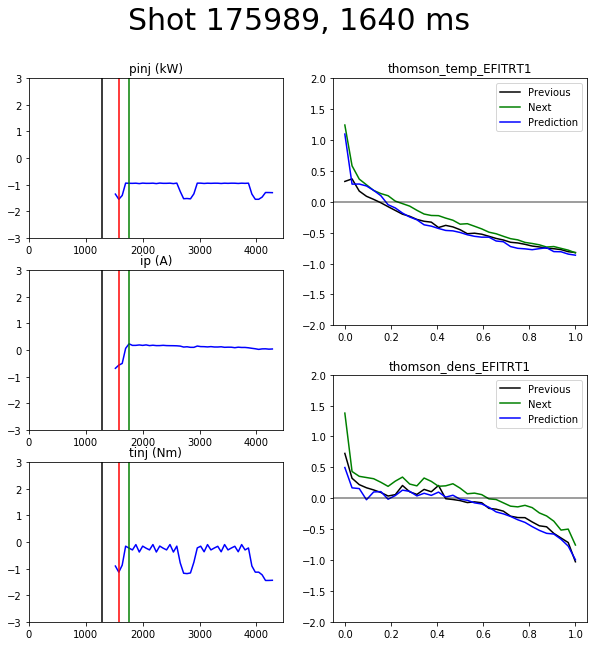

In [82]:
plt.rcParams["figure.figsize"] = (10,10)

all_shots=np.unique(traindata['shotnum'])
shotnum=175989 #np.random.choice(all_shots) #179118
t+=200 #np.random.choice([1500,2000,2500])
plot_prediction_for_shot_at_time(shotnum,t,denormalized=False)

In [239]:
basedir='/home/jabbate/pics'

shotnum=175673 #np.random.choice(all_shots)
shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]
time_offset=abs(traindata['time'][shot_indices,-scenario['lookahead']])
for i,t in enumerate(time_offset):
    plot_prediction_for_shot_at_time(shotnum,t,filename=os.path.join(basedir,'{}_{:02d}.png'.format(int(shotnum),i)))

/home/jabbate/pics/175673_00.png
/home/jabbate/pics/175673_01.png
/home/jabbate/pics/175673_02.png
/home/jabbate/pics/175673_03.png
/home/jabbate/pics/175673_04.png
/home/jabbate/pics/175673_05.png
/home/jabbate/pics/175673_06.png
/home/jabbate/pics/175673_07.png
/home/jabbate/pics/175673_08.png
/home/jabbate/pics/175673_09.png
/home/jabbate/pics/175673_10.png
/home/jabbate/pics/175673_11.png
/home/jabbate/pics/175673_12.png
/home/jabbate/pics/175673_13.png
/home/jabbate/pics/175673_14.png
/home/jabbate/pics/175673_15.png
/home/jabbate/pics/175673_16.png
/home/jabbate/pics/175673_17.png
/home/jabbate/pics/175673_18.png
/home/jabbate/pics/175673_19.png
/home/jabbate/pics/175673_20.png
/home/jabbate/pics/175673_21.png
/home/jabbate/pics/175673_22.png
/home/jabbate/pics/175673_23.png
/home/jabbate/pics/175673_24.png
/home/jabbate/pics/175673_25.png
/home/jabbate/pics/175673_26.png
/home/jabbate/pics/175673_27.png
/home/jabbate/pics/175673_28.png
/home/jabbate/pics/175673_29.png
/home/jabb

In [73]:
print()

[ 800.  860.  920.  980. 1040. 1100. 1160. 1220. 1280. 1340. 1400. 1460.
 1520. 1580. 1640. 1700. 1760. 1820. 1880. 1940. 2000. 2060. 2120. 2180.
 2240. 2300. 2360. 2420. 2480. 2540. 2600. 2660. 2720. 2780. 2840. 2900.
 2960. 3020.]


# Make the colorbar plots

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['font.size'] = 22

import numpy as np
import matplotlib.pyplot as plt

shots=list(data.keys())
shot=170701 #np.random.choice(shots)
sigs=['curr','temp','pinj','tinj','dens','gasA','ech'] #['ffprime_EFITRT1','curr_target','pinj','temp','dens','gas_feedback','target_density','gasA','gasA_voltage', 'beam_feedback_switch', 'beam_feedback_power_target_quantity', 'realtime_betan']
sig_names={'curr': 'Current\n(MA)',
           'temp':'Electron Temperature\n(keV)', 
           'dens': 'Electron Density\n(10^19 cm^-3)',
           'itemp':'Ion Temperature\n(keV)', 
           'pinj': 'NB Power\n(MW)', 
           'gasA': 'Gas\n(V)',
           'ech': 'ECH Power\n(MW)',
           'tinj': 'NB Torque\n(Rad/s)'}
conversion_factor={'temp': 1000,
                  'dens':1e19,
                  'pinj': 1000,
                  'tinj': 1,
                  'curr': 1e6,
                  'gasA': 1,
                  'ech': 1}

#sigs=['curr_target','pinj','temp','dens','target_source_pinj_30L','beam_feedback_switch','beam_feedback_switch','beam_feedback_power_target_quantity','beam_feedback_power_target_value','realtime_betan']
assert(all(data[shot]['gas_density_or_profile_algorithm']==0))

def removeOutliers(x, outlierConstant, sig):
    #upper_quartile = np.nanpercentile(x, 75)
    #lower_quartile = np.nanpercentile(x, 25)
    upper_quartile=quartiles[sig]['upper']
    lower_quartile=quartiles[sig]['lower']
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    return np.clip(x,lower_quartile - IQR,upper_quartile + IQR)


def my_normalize(arr):
    return (arr-np.nanmin(arr))/(np.nanmax(arr)-np.nanmin(arr))

fig=plt.figure()
for i,sig in enumerate(sigs):
    ax=fig.add_subplot(len(sigs),1.5,i+1)
    ax.axvline(data[shot]['t_ip_flat'],c='r')
    ax.axvline(data[shot]['t_ip_flat']+data[shot]['ip_flat_duration'],c='r')
    if sig in ['temp','dens']: #len(data[shot][sig].shape)>1:
        #thomson_sig_name='thomson_{}_EFITRT1'.format(sig)
        #thomson_sig=data[shot][thomson_sig_name]
        #thomson_sig=removeOutliers(thomson_sig,1.5,thomson_sig_name)
        #ax.plot(data[shot]['time'],my_normalize(data[shot]['pinj']),c='r')
            
        zipfit_sig=np.mean(data[shot][sig],axis=1) #my_normalize(np.mean(data[shot][sig],axis=1))
        
        ax.contourf(data[shot]['time'],
            np.linspace(0,np.nanmax(data[shot][sig]),65),
            #thomson_sig.T)
            data[shot][sig].T)
        
        ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
        ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3,label='Fitted')
        
        #thomson_sig=np.mean(thomson_sig,axis=1)/conversion_factor[sig] #my_normalize(np.mean(thomson_sig,axis=1))
        #ax.plot(data[shot]['time'],thomson_sig,c='b',linewidth=7,label='Raw Thomson')
        #ax.legend()
        #ax.plot(data[shot]['time'],my_normalize(np.mean(data[shot]['thomson_{}_EFITRT1'.format(sig)],axis=1), clip=True, sig=sig),c='g',linewidth=3)
    elif len(data[shot][sig].shape)>1:
        thomson_sig=removeOutliers(data[shot][sig],1.5,sig)
        
        ax.contourf(data[shot]['time'],
                    np.linspace(0,1,65),
                    #thomson_sig.T)
                    data[shot][sig].T)
            
#         zipfit_sig=my_normalize(np.mean(data[shot][sig],axis=1))
#         ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
#         ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3)
        
       
    elif sig=='target_density':
        ax.plot(data[shot]['time'],data[shot]['density_estimate'])
        ax.plot(data[shot]['time'],data[shot]['target_density'],c='r')
    elif sig=='realtime_betan':
        ax.plot(data[shot]['time'],data[shot]['realtime_betan'])
        ax.plot(data[shot]['time'],data[shot]['beam_feedback_power_target_value'],c='r')
    elif sig=='curr_target':
        ax.plot(data[shot]['time'],data[shot]['curr'])
        ax.plot(data[shot]['time'],data[shot]['curr_target'],c='r')
        
    else:
        ax.plot(data[shot]['time'],data[shot][sig]/conversion_factor[sig])
    ax.set_ylabel(sig_names[sig])
    ax.set_xlim(min(data[shot]['time']),max(data[shot]['time']))
    #ax.axvline(2220)
    #ax.axvline(2270)
plt.xlabel('Time (ms)')
#plt.subplots_adjust(hspace=.5)
fig.suptitle('Shot {}'.format(shot),fontsize=30)
plt.show()